In [1]:
import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [2]:
b = 0.5

In [3]:
def solution_1D(x):
  return -x**2/2 +x +b/2/(1-b)

In [6]:
x = torch.linspace(0,2,1000).unsqueeze(-1)

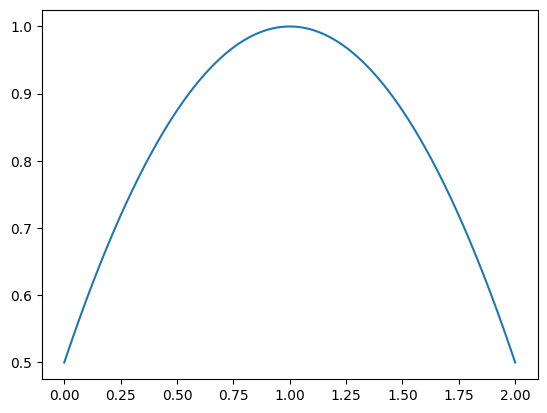

In [7]:
plt.plot(x, solution_1D(x))

In [4]:
def reconstr(f, x):
  g = f(x)
  g[x<=1] -= b*f(x[x<=1]+1)
  g[x>1] -= b*f(x[x>1]-1)
  return g/(1-b**2)
def reconstr_1D(x):
  return reconstr(solution_1D, x)

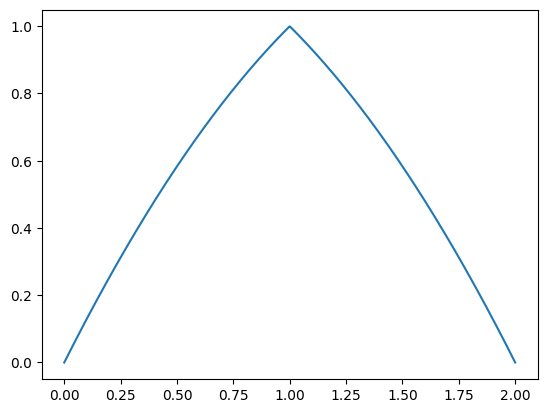

In [9]:
plt.plot(x, reconstr_1D(x))

In [ ]:
solution_1D(x).shape, reconstr_1D(x).shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [5]:
# Define the function FQ
def FQ_1D(f, x):
    mask = (x[:,0] >=0) & (x[:,0]<=2)
    result = torch.zeros((x.shape[0],1), device=x.device)
    result[mask] = (x[mask,0]*(x[mask,0]-2)).unsqueeze(-1)*f(x[mask])
    return result

# Define the function RQ
def RQ_1D(fq, model1, x):
    x1 = torch.zeros_like(x, device=x.device)
    x1[:, 0] = 1.0  # Setting x1[:,0] to 1, for the shifting operations
    return fq(model1, x) + b * fq(model1, x + x1) + b * fq(model1, x - x1)

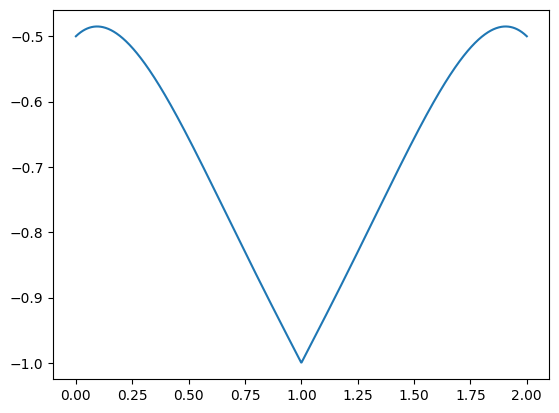

In [ ]:
plt.plot(x, RQ_1D(FQ_1D, reconstr_1D, x))

In [6]:
def right_hand_side(x):
  return torch.ones_like(x) #torch.sin(np.pi*x[:,1]).unsqueeze(-1)

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.fc(x)
        out = self.relu(out)
        out = out + residual
        return out

In [8]:
class ResidualModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=20, output_size=1, num_layers=4):
        super(ResidualModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([ResidualBlock(hidden_size) for _ in range(num_layers)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.input_layer(x)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
        out = self.output_layer(out)
        return out

In [9]:
input_size = 1
hidden_size = 20
output_size = 1
num_layers = 14

model = ResidualModel(input_size, hidden_size, output_size, num_layers)

In [ ]:
#model(x)

In [ ]:
RQ_1D(FQ_1D, model, x).shape

torch.Size([1000, 1])

In [13]:
x = torch.linspace(0,2,1000).unsqueeze(-1) # randn(2, 2, dtype=torch.float32, requires_grad=True)

In [ ]:
x.shape

torch.Size([100, 1])

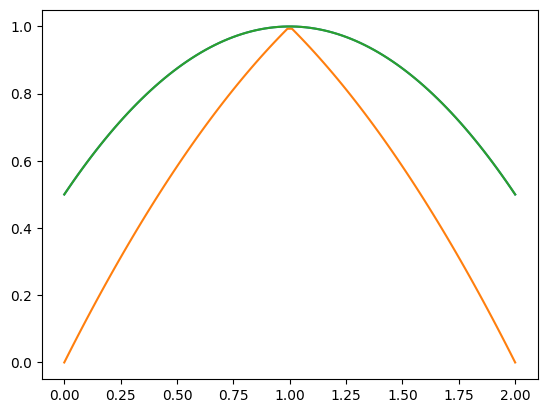

In [ ]:
plt.plot(x, solution_1D(x,b=0.5))
plt.plot(x, f_1D(x))
plt.plot(x, RQ_1D(FQ_1D, f_1D, x))

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set up the learning rate scheduler to decrease the learning rate by a factor of 0.1 every 100 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [18]:
batch_size = 1600
for epoch in range(10000):
    model.train()
    scale = torch.ones((batch_size,1))
    scale[:,0] = 2*scale[:,0]
    x0 = torch.rand(batch_size, input_size, dtype=torch.float32, requires_grad=True)*scale
    gradients_1 = torch.autograd.grad(outputs=RQ_1D(FQ_1D, model, x0).sum(), inputs=x0, create_graph=True)[0]
    gradients_2 = torch.autograd.grad(outputs=((x0[:,0]*(x0[:,0]-2)).unsqueeze(-1)*model(x0)).sum(), inputs=x0, create_graph=True)[0]
    #loss = torch.mean((gradients - 2*right_hand_side(x0))*(x0[:,0]*(x0[:,0]-2)*x0[:,1]*(x0[:,1]-1)).unsqueeze(-1)*model(x0))
    slopes = torch.sum(gradients_1*gradients_2, dim=-1).unsqueeze(-1)
    #slopes = torch.square(gradients[:,0]) + torch.square(gradients[:,1])
    loss = torch.mean(slopes - 2*(x0[:,0]*(x0[:,0]-2)).unsqueeze(-1)*model(x0)*right_hand_side(x0))
    #loss = torch.mean(slopes - 2*RQ(FQ, model, x0)*right_hand_side(x0))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    if epoch%100==0:
        model.eval()
        with torch.no_grad():
            x1 = torch.linspace(0, 2, steps=200)
            x2 = torch.linspace(0, 1, steps=100)
            x0 = torch.cartesian_prod(x1, x2)
            x0 = torch.rand(batch_size, input_size, dtype=torch.float32)
            u = (x0[:,0]*(x0[:,0]-2)).unsqueeze(-1)*model(x0) #RQ_1D(FQ_1D, (x0[:,0]*(x0[:,0]-2)).unsqueeze(-1)*model, x0) # (x0[:,0]*(x0[:,0]-2)*x0[:,1]*(x0[:,1]-1)).unsqueeze(-1)*model(x0)
            u_predict = reconstr_1D(x0) #exact_solution(x0)
            print(torch.mean(torch.abs(u - u_predict)))



tensor(0.0106)
tensor(0.0106)
tensor(0.0107)
tensor(0.0106)
tensor(0.0107)


KeyboardInterrupt: 

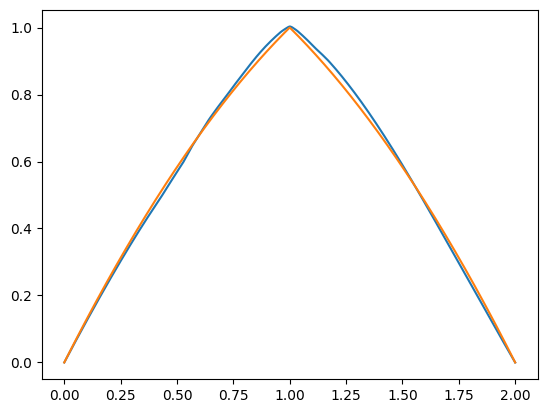

In [17]:
plt.plot(x, x*(x-2)*model(x).detach().numpy())
plt.plot(x, reconstr_1D(x).detach().numpy())

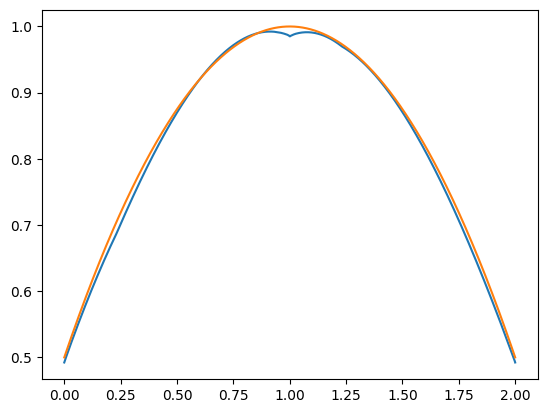

In [35]:
plt.plot(x, RQ_1D(FQ_1D, model, x).detach().numpy())
plt.plot(x, solution_1D(x).detach().numpy())